In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import urllib
import requests
import os
import io
import json
import pylab as plt
import shapely
from fiona.crs import from_epsg

%pylab inline

import choroplethNYC as cp
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
if os.getenv("PUIDATA") is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
os.getenv("PUIDATA")

'/nfshome/tn1050/PUIdata'

In [3]:
url = 'https://data.cityofnewyork.us/api/views/8ktu-ngtj/rows.csv?accessType=DOWNLOAD'
df = pd.read_csv(url)
df.head(10)

,INCIDENT_ADDRESS,BOROUGH,COMMUNITY_BOARD,POLICE_PRECINCT,CITY_COUNCIL_DISTRICT,BBL,CREATED_DATE,STATUS,RESOLUTION_ACTION,CLOSED_DATE,...,ZIP_CODE,CENSUS_TRACT,BIN,NTA,LOCATION,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,702 U AVENUE,BROOKLYN,15 BROOKLYN,Precinct 61,47.0,3.071340e+09,01/17/2018,Open,Site downloaded for cleaning,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,west 132 street and 8th avenue,MANHATTAN,Unspecified MANHATTAN,Unspecified,NaN,NaN,01/17/2018,Open,Property Research Required,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101 101 ave,QUEENS,01 QUEENS,Unspecified,NaN,NaN,12/07/2017,Open,Property Research Required,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1243 AH,BROOKLYN,01 BROOKLYN,Unspecified,NaN,NaN,12/11/2017,Open,Property Research Required,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2361 castle hill ave,BRONX,01 BRONX,Unspecified,NaN,NaN,01/03/2018,Open,Property Research Required,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,123 west dykman,MANHATTAN,Unspecified MANHATTAN,Unspecified,NaN,NaN,12/26/2017,Open,Property Research Required,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,78 WEST 8 STREET,MANHATTAN,Unspecified MANHATTAN,Unspecified,NaN,NaN,12/18/2017,Open,Property Research Required,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,139 139 street,QUEENS,01 QUEENS,Unspecified,NaN,NaN,12/12/2017,Open,Property Research Required,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,718 5 avenueue,BROOKLYN,01 BROOKLYN,Unspecified,NaN,NaN,11/16/2017,Open,Property Research Required,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9701 ROCKAWAY PARKWAY,BROOKLYN,01 BROOKLYN,Unspecified,NaN,NaN,12/09/2017,Open,Property Research Required,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
set(df.RESOLUTION_ACTION)

{'Cleaning crew dispatched.  Cannot locate property.',
 'Cleaning crew dispatched.  Owner refused.',
 'Cleaning crew dispatched.  Property cleaned.',
 'Cleaning crew dispatched. No graffiti on property.',
 'Further research is necessary to identify an owner for the property.',
 'Graffiti Reported',
 'Graffiti is intentional.',
 'Graffiti is not on property reported',
 'Mail returned / wrong address',
 'Notice of Intent to Clean and Forever graffiti free form sent',
 'Property Research Required',
 'Public Property (Non-City)',
 'Site downloaded for cleaning',
 'Site to be cleaned.'}

In [5]:
set(df[df.CLOSED_DATE.notna()].RESOLUTION_ACTION)

{'Cleaning crew dispatched.  Cannot locate property.',
 'Cleaning crew dispatched.  Owner refused.',
 'Cleaning crew dispatched.  Property cleaned.',
 'Cleaning crew dispatched. No graffiti on property.',
 'Graffiti is intentional.'}

In [6]:
### Will only focus on the data where grafitti was detected, 
### cleaning crew was dispatched, and property was cleaned.

df_cleaned = df[df.RESOLUTION_ACTION == 'Cleaning crew dispatched.  Property cleaned.']
display(df_cleaned.head())
df_toClean = df[df.RESOLUTION_ACTION.isin(['Site downloaded for cleaning', 'Site to be cleaned.'])]
display(df_toClean.head())

,INCIDENT_ADDRESS,BOROUGH,COMMUNITY_BOARD,POLICE_PRECINCT,CITY_COUNCIL_DISTRICT,BBL,CREATED_DATE,STATUS,RESOLUTION_ACTION,CLOSED_DATE,...,ZIP_CODE,CENSUS_TRACT,BIN,NTA,LOCATION,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
57,1237 U AVENUE,BROOKLYN,15 BROOKLYN,Precinct 61,48.0,3.073170e+09,11/21/2017,Closed,Cleaning crew dispatched. Property cleaned.,02/26/2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,94-52 CORONA AVENUE,QUEENS,04 QUEENS,Precinct 110,25.0,4.018770e+09,11/29/2017,Closed,Cleaning crew dispatched. Property cleaned.,02/21/2018,...,11373.0,461.0,4046361.0,Elmhurst,"(40.742294, -73.86949)",14784.0,66.0,3.0,5.0,68.0
169,215-29 JAMAICA AVENUE,QUEENS,13 QUEENS,Precinct 105,23.0,4.106080e+09,11/17/2017,Closed,Cleaning crew dispatched. Property cleaned.,02/27/2018,...,11428.0,566.0,4226337.0,Queens Village,"(40.717357, -73.739683)",24337.0,63.0,3.0,16.0,63.0
227,972 MCDONALD AVENUE,BROOKLYN,12 BROOKLYN,Precinct 66,44.0,3.054390e+09,11/16/2017,Closed,Cleaning crew dispatched. Property cleaned.,02/26/2018,...,11230.0,476.0,3128735.0,Borough Park,"(40.630189, -73.977069)",13513.0,2.0,2.0,18.0,39.0
252,113 FRANKLIN STREET,BROOKLYN,01 BROOKLYN,Precinct 94,33.0,3.025570e+09,11/16/2017,Closed,Cleaning crew dispatched. Property cleaned.,02/28/2018,...,11222.0,565.0,3337033.0,Greenpoint,"(40.729984, -73.957623)",18182.0,36.0,2.0,38.0,57.0


,INCIDENT_ADDRESS,BOROUGH,COMMUNITY_BOARD,POLICE_PRECINCT,CITY_COUNCIL_DISTRICT,BBL,CREATED_DATE,STATUS,RESOLUTION_ACTION,CLOSED_DATE,...,ZIP_CODE,CENSUS_TRACT,BIN,NTA,LOCATION,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,702 U AVENUE,BROOKLYN,15 BROOKLYN,Precinct 61,47.0,3.071340e+09,01/17/2018,Open,Site downloaded for cleaning,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,119 D AVENUE,MANHATTAN,03 MANHATTAN,Precinct 9,2.0,1.003780e+09,12/20/2017,Open,Site downloaded for cleaning,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,1916 U AVENUE,BROOKLYN,15 BROOKLYN,Precinct 61,48.0,3.073520e+09,12/16/2017,Open,Site downloaded for cleaning,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,2307 U AVENUE,BROOKLYN,15 BROOKLYN,Precinct 61,48.0,3.073280e+09,11/21/2017,Open,Site downloaded for cleaning,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,27-07 44 DRIVE,QUEENS,02 QUEENS,Precinct 108,26.0,4.002680e+09,02/09/2018,Open,Site downloaded for cleaning,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Archive:  files.zip
  inflating: /nfshome/tn1050/PUIdata/geo_export_f0ce3bd7-0e10-4288-a66e-d3b3d3da46d3.dbf  rm: cannot remove '/nfshome/tn1050/PUIdata/geo*': No such file or directory

  inflating: /nfshome/tn1050/PUIdata/geo_export_f0ce3bd7-0e10-4288-a66e-d3b3d3da46d3.shp  
  inflating: /nfshome/tn1050/PUIdata/geo_export_f0ce3bd7-0e10-4288-a66e-d3b3d3da46d3.shx  
  inflating: /nfshome/tn1050/PUIdata/geo_export_f0ce3bd7-0e10-4288-a66e-d3b3d3da46d3.prj  


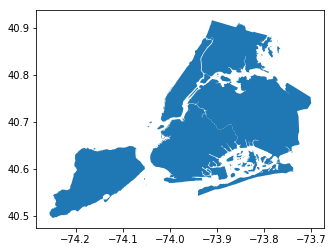

In [7]:
# Getting NYC Borough Map --> so it's not too heavy to load and plot.
url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
urllib.request.urlretrieve(url, "files.zip")
! rm $PUIDATA/geo* | unzip -o files.zip -d $PUIDATA # Removing all previous geo export files from my directory before unzipping another one
shp_file = ! ls $PUIDATA | grep .shp # Fething the 1 shp file that I just extracted
df_map = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA')+'/'+shp_file[0]) 
df_map.plot()

In [8]:
df_map

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((-74.01092841268031 40.6844914725429...
1,2.0,Bronx,1.186615e+09,463464.521828,(POLYGON ((-73.89680883223774 40.7958084451597...
2,5.0,Staten Island,1.623921e+09,330432.867999,(POLYGON ((-74.05050806403247 40.5664220341608...
3,3.0,Brooklyn,1.937567e+09,739945.437431,(POLYGON ((-73.86706149472118 40.5820879767934...
4,4.0,Queens,3.044772e+09,895228.960360,(POLYGON ((-73.83668274106707 40.5949466970158...


In [14]:
tmp = df_cleaned[df_cleaned.LOCATION.notnull()]
tmp['geometry'] = list(zip(tmp.LONGITUDE, tmp.LATITUDE))
tmp['geometry'] = tmp['geometry'].apply(Point)
gdf = gpd.GeoDataFrame(tmp, geometry='geometry', crs=df_map.crs)

/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/tn1050/.conda/envs/geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
gdf['CREATED_DATE'] = pd.to_datetime(gdf['CREATED_DATE'])
gdf['CLOSED_DATE'] = pd.to_datetime(gdf['CLOSED_DATE'])
gdf['duration'] = gdf['CLOSED_DATE'] - gdf['CREATED_DATE']
gdf.dtypes

INCIDENT_ADDRESS                   object
BOROUGH                            object
COMMUNITY_BOARD                    object
POLICE_PRECINCT                    object
CITY_COUNCIL_DISTRICT             float64
BBL                               float64
CREATED_DATE               datetime64[ns]
STATUS                             object
RESOLUTION_ACTION                  object
CLOSED_DATE                datetime64[ns]
X_COORDINATE                      float64
Y_COORDINATE                      float64
LATITUDE                          float64
LONGITUDE                         float64
ZIP_CODE                          float64
CENSUS_TRACT                      float64
BIN                               float64
NTA                                object
LOCATION                           object
Zip Codes                         float64
Community Districts               float64
Borough Boundaries                float64
City Council Districts            float64
Police Precincts                  

In [16]:
tmp = df_toClean.groupby('BOROUGH').count().reset_index()
tmp = tmp[['BOROUGH', 'STATUS']]

df_map['BOROUGH'] = [i.upper() for i in df_map.boro_name]

df_merged = df_map.merge(tmp, how='left')
df_merged

,boro_code,boro_name,shape_area,shape_leng,geometry,BOROUGH,STATUS
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((-74.01092841268031 40.6844914725429...,MANHATTAN,1174
1,2.0,Bronx,1.186615e+09,463464.521828,(POLYGON ((-73.89680883223774 40.7958084451597...,BRONX,634
2,5.0,Staten Island,1.623921e+09,330432.867999,(POLYGON ((-74.05050806403247 40.5664220341608...,STATEN ISLAND,19
3,3.0,Brooklyn,1.937567e+09,739945.437431,(POLYGON ((-73.86706149472118 40.5820879767934...,BROOKLYN,2051
4,4.0,Queens,3.044772e+09,895228.960360,(POLYGON ((-73.83668274106707 40.5949466970158...,QUEENS,887


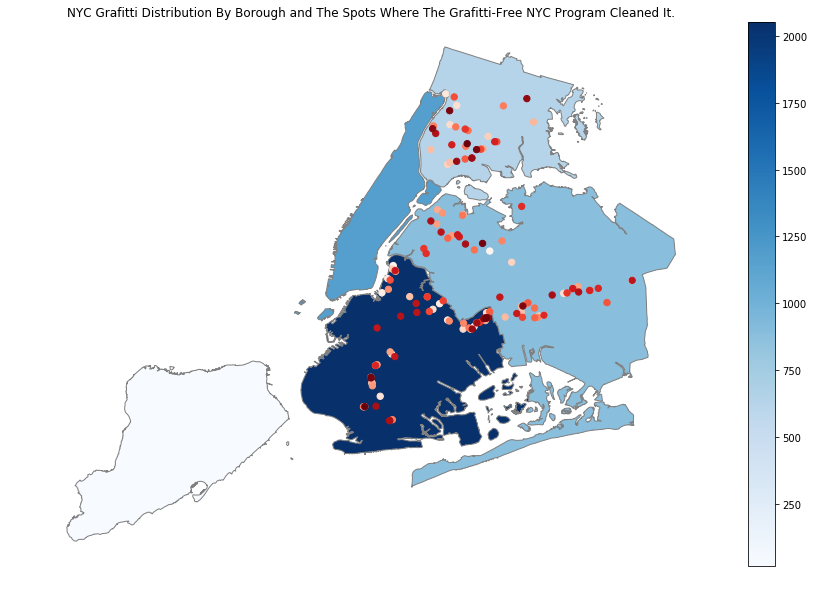

In [20]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, frameon=False)
ax.axis('off')

df_merged.plot(ax=ax, column='STATUS', cmap="Blues", legend=True, edgecolor='grey')
gdf.plot(c=gdf.duration, cmap='Reds', ax=ax, markersize=40)

ax.set_title('NYC Grafitti Distribution By Borough and The Spots Where The Grafitti-Free NYC Program Cleaned It.')

fig.savefig(os.getcwd()+'/plot.png')

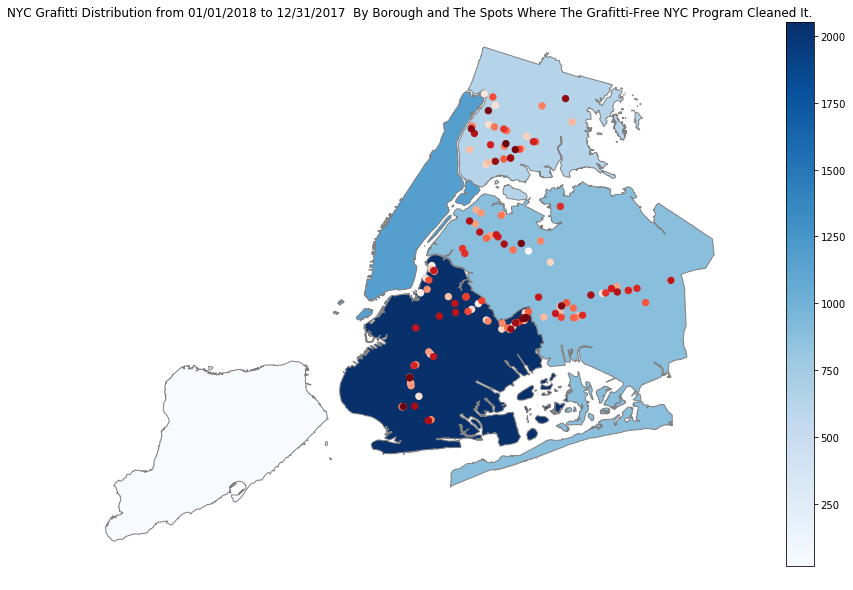

In [23]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, frameon=False)
ax.axis('off')

df_merged.plot(ax=ax, column='STATUS', cmap="Blues", legend=True, edgecolor='grey')
gdf.plot(c=gdf.duration, cmap='Reds', ax=ax, markersize=40)

ax.set_title(f'NYC Grafitti Distribution from {min(df.CREATED_DATE)} to {max(df.CREATED_DATE)}  By Borough and The Spots Where The Grafitti-Free NYC Program Cleaned It.')

fig.savefig(os.getcwd()+'/../HW11_tn1050/plot2.png')